<a href="https://colab.research.google.com/github/huytranvan2010/GANs-Tutorial/blob/master/GANs_mnist_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trong bài này mình sẽ xây dựng mô hình GANs với tập dữ liệu MNIST. Ở đây chúng ta sẽ sử dụng MPL, trong bài sau chúng ta sẽ dùng kết hợp với Convolutional layer.

Chúng ta sẽ đi xây dựng generator model và discriminator model. Sau đó sẽ kết hợp 2 model đó lại để tại thành GAN model, thông qua GAN model chúng ta sẽ train được generator model (do update weights của generator dựa trên performance của discriminator). 

Chúng ta sẽ train xen kẽ discriminator và genarotor. Khi train generator thông qua GAN model chúng ta phải freeze discriminator weights lại vì không muốn cập nhật weights của nó (generator chỉ nhờ discriminator đánh giá hộ ảnh nó tạo ra thôi).

In [14]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Load và kiểm tra data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print("Shape x_train: ", X_train.shape, "Shape Y_train: ", Y_train.shape)
print("Shape x_train: ", X_test.shape, "Shape Y_train: ", Y_test.shape)

Shape x_train:  (60000, 28, 28) Shape Y_train:  (60000,)
Shape x_train:  (10000, 28, 28) Shape Y_train:  (10000,)


### Hiển thị dữ liệu

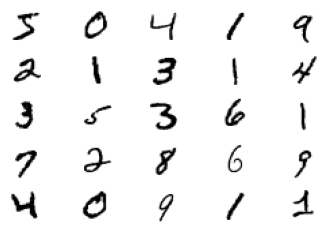

In [15]:
n = 5
for i in range(n * n):
    plt.subplot(n, n, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i], cmap='gray_r')   # hiển thị ở matplotlib thì chỉ cần 2 kích thước width và height
plt.show()


### Tiền xử lý dữ liệu
Chúng ta reshape lại, mỗi ảnh thành thành 1 vector 784 chiều, **chuyển về float do đang ở unsigned integer**, rescale về [0,1] (có thể rescale về [-1, 1] cũng được, **chú ý activation function cũng thay đổi theo).**

In [16]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Một số cài đặt
- Latent space: lấy vetor có chiều 100
- Optimizer: Adam với learning rate 0.0002, beta_1 = 0.5

In [17]:
# Số chiều của noise trong latent space
z_dim = 100

# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Xây dựng **generator model**, chúng ta có số lượng units của các hidden layers lần lượt là 256, 512, 1024, 784. Output layer có số units là 784 do nó được dùng làm đầu vào của discriminator. Discriminator cũng nhận ảnh từ MNIST dataset, sau khi duỗi ra là vector có 784 chiều.

In [18]:
g = Sequential()
# Dense thì chúng ta dùng input_dim và nhập vào số chiều, khác với Conv2D cần input_shape và cần dạng tuple
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))

g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))

g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))

g.add(Dense(784, activation='sigmoid'))  # Để output nằm trong [0, 1] phù hợp với MNIST đã chuẩn hóa, tí còn cho vào discriminaor

g.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])  # ko cần compile chỗ này cũng được vì train theo compisite model

Xây dựng **discriminator model**

In [19]:
d = Sequential()
# input_dim nha (ko phải input_shape)
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))

d.add(Dropout(0.3))

d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))

d.add(Dropout(0.3))

d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))

d.add(Dropout(0.3))

d.add(Dense(1, activation='sigmoid'))  # Bài toán phân loại

d.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])


Xây dựng GAN model, gộp bởi generator và discriminator. Chúng ta dùng GAN mdoel để train generator.

In [20]:
# NÊN KHỞI TẠO CÁC MODEL TRONG HÀM CHO DỄ QUẢN LÝ
d.trainable = False     # khi train generator thông qua GAN model thì freeze discriminator lại

# Định nghĩa input 
input = Input(shape=(z_dim, ))     # Input layer thì lại là shape

hidden = g(input)      # đi qua generator model

output = d(hidden)      # đầu ra của generator model đi qua discriminator

gan = Model(inputs=input, outputs=output)

gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
# thực chất ở đây mới cần compile model, ở trên generator không cần compile model.

## Tạo một số hàm phụ trợ

In [21]:
# Hiển thị loss của discriminator và generator
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    #d_acc = [v[1] for v in losses["D"]]
    #g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    #plt.plot(d_acc, label="Discriminator accuracy")
    #plt.plot(g_acc, label="Generator accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [22]:
# hiển thị ảnh được tạo ra từ generator
def plot_generated(n_ex = 10, dim = (1, 10), figsize = (12, 2)):    # in ra 10 examples
    noise = np.random.randn(n_ex, z_dim)
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)   # reshape để hiển thị trên matplotlib

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Train models

In [25]:
# dict để lưu loss của discriminator và generator
losses = {"D":[], "G":[]}

def train(epochs = 1, plt_frq = 1, BATCH_SIZE = 128):   # plt_frq tần suất vẽ hình
    # số batches trong mỗi epoch
    batchCount = X_train.shape[0] // BATCH_SIZE
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for i in tqdm_notebook(range(1, epochs+1)):     # để hiển thị thêm thì bao tqdm_notebook quanh iterators
        if i == 1 or i % plt_frq == 0:
            print('-'*15, 'Epoch %d' % i, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # UPDATE cho discriminator
            # Lấy ngẫu nhiên ảnh từ MNIST dataset (real samples)
            X_real = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # gán nhãn cho data từ MNIST
            y_real = np.ones((BATCH_SIZE, 1)) - 0.1     # để label = 0.9 smoothing label

            # Tạo points (noise) trong latent space
            noise = np.random.randn(BATCH_SIZE, z_dim)  # ở đây ko cần để dạng tuple
            # generated images từ points đi qua generator (fake samples)
            X_fake = g.predict(noise)
            y_fake = np.zeros((BATCH_SIZE, 1))      # để 2d-array, nếu để mỗi BATCH_SIZE thì stack theo horizontal

            # Nối lại real samples + fake samples
            X = np.vstack((X_real, X_fake))
            y = np.vstack((y_real, y_fake))

            # Train discriminator on generated images (fake sample) + real samples
            d.trainable = True  # cập nhật weights của discriminator
            d_loss = d.train_on_batch(X, y)     # train trên collection of data nào đó, chỗ này trả về list of loss và metric, ko có metric khi compile thì trả về loss

            # Nếu mình không tạo các model trong hàm sẽ không phải set lại d.trainable như này, đến bài sau sẽ rõ hơn
            # Train generator
            X_gan = np.random.randn(BATCH_SIZE, z_dim)
            y_gan = np.ones((BATCH_SIZE, 1))
            d.trainable = False     # ko cập nhật wieghts của discriminator, nếu đưa vào hàm thì freeze rồi ko cần quan tâm
            g_loss = gan.train_on_batch(X_gan, y_gan)   # ở đây cũng trả về list loss và metric, nếu ko có metric khi compile thì trả về loss

        # lưu loss cuối mỗi epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Hiển thị các số được sinh ra để kiểm tra
        if i == 1 or i % plt_frq == 0:
            plot_generated()

    plot_loss(losses)   # vẽ loss

Epochs: 40
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/40 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


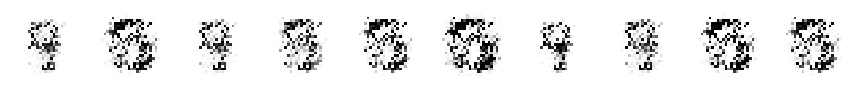

--------------- Epoch 20 ---------------


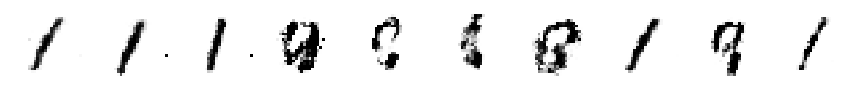

--------------- Epoch 40 ---------------


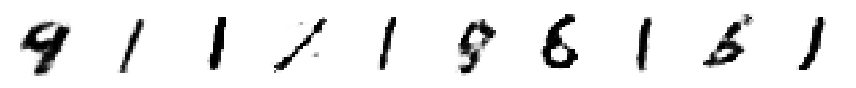

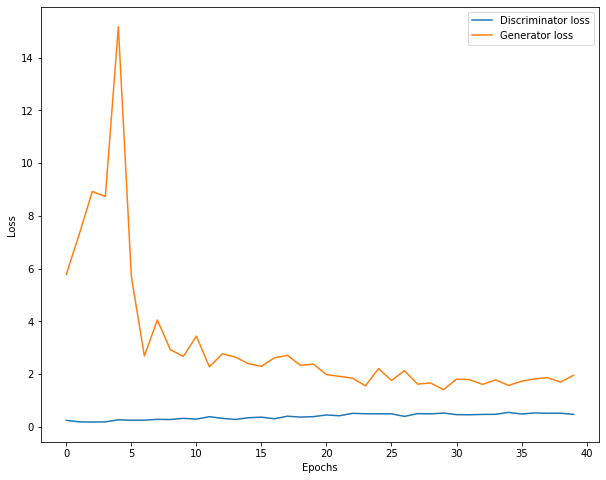

In [26]:
# Train GAN model
train(epochs=40, plt_frq=20, BATCH_SIZE=128)